In [1]:
import pickle
with open('con_loaded_data_2000.pickle', 'rb') as f:
    DATA = pickle.load(f) 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv1D, Flatten, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, AveragePooling1D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np

import librosa 
import librosa.display
import pylab
import cv2
import os

Using TensorFlow backend.


In [3]:
class CustomDatase_1D(tf.keras.utils.Sequence):
    def __init__(self,imgfiles, batch_size,target_size=(128,128),shuffle=False,scale=255,n_classes=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, x = self.__data_generation(indexes)
        return X, x

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def timeshift(self, img, shift=5, direction='right', roll=True):
        assert direction in ['right', 'left'], 'Directions should be left|right'
        img = img.copy()
        if direction == 'right':
            right_slice = img[:, -shift:].copy()
            img[:, shift:] = img[:, :-shift]
            if roll:
                img[:,:shift] = np.fliplr(right_slice)
        if direction == 'left':
            left_slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            if roll:
                img[:, -shift:] = left_slice
        return img
    
    def block_masking(self, wav, T=20, F=15, time_mask_num=1, freq_mask_num=1):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            for _ in range(freq_mask_num):
                f = np.random.uniform(low=0.0, high=F)
                f = int(f)
                f0 = random.randint(0, feat_size - f)
                
                wav[t0 : t0 + t, f0 : f0 + f] = 0
        return wav            
    
    def spec_augment(self, wav, T=20, F=15, time_mask_num=2, freq_mask_num=2):
        feat_size = wav.shape[0]
        seq_len = wav.shape[1]
          # freq mask
        for _ in range(time_mask_num):
            t = np.random.uniform(low=0.0, high=T)
            t = int(t)
            t0 = random.randint(0, seq_len - t)
            wav[t0 : t0 + t] = 0
        # time mask
        for _ in range(freq_mask_num):
            f = np.random.uniform(low=0.0, high=F)
            f = int(f)
            f0 = random.randint(0, feat_size - f)
            wav[:, f0 : f0 + f] = 0
        return wav

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim))
        x = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            img = self.timeshift(img)
            
            img2   = cv2.imread(self.imgfiles[ID])
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            img2   = cv2.resize(img2,self.dim,interpolation = cv2.INTER_CUBIC)
            img2 = self.block_masking(img2)
            
            X[i,] = img / self.scale
            x[i,] = img2 / self.scale

            self.c +=1
        return X, x #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class specGenerator_1D(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, batch_size,target_size=(128,128)):
        self.genX2 = CustomDatase_1D(X2,batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, X_2_batch = self.genX2.__getitem__(index)
        return X_batch, X_2_batch

In [4]:
def build_model_1D():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64))
    lay1_  = Conv1D(64, 3, strides=2)(inp2)
    lay2_  = AveragePooling1D(2, strides=2)(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv1D(128, 3, padding="same") (lay4_)
    lay6_  = AveragePooling1D(2, strides=2) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv1D(128, 3, padding="same") (lay8_)
    lay10_ = AveragePooling1D(2, strides=2) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.5)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    x = tf.keras.layers.Dense(256)(lay13_)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    MERGM   = Model(inputs=inp2, outputs=lay15_)

    return MERGM

In [5]:
import tensorflow.keras.backend as K

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

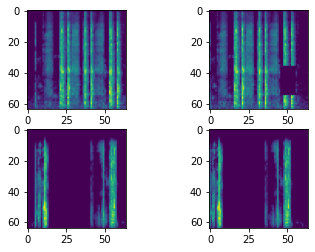

loss tf.Tensor(7.541554, shape=(), dtype=float32)


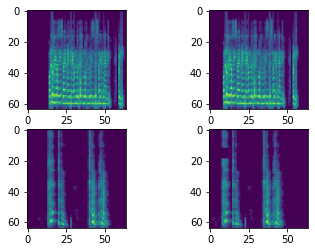

loss tf.Tensor(7.5279927, shape=(), dtype=float32)


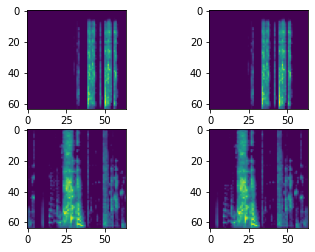

loss tf.Tensor(7.517178, shape=(), dtype=float32)


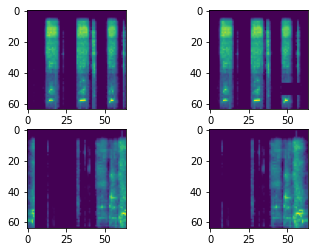

loss tf.Tensor(7.505194, shape=(), dtype=float32)


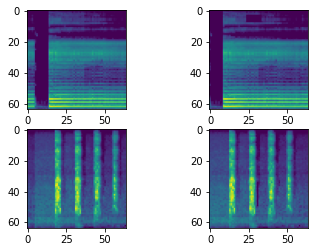

loss tf.Tensor(7.497796, shape=(), dtype=float32)


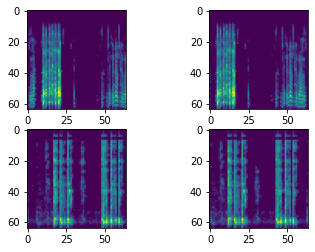

loss tf.Tensor(7.470684, shape=(), dtype=float32)


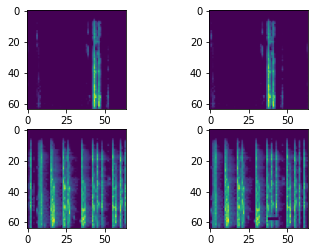

loss tf.Tensor(7.4660907, shape=(), dtype=float32)


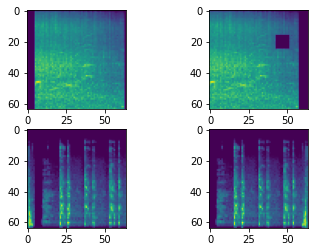

loss tf.Tensor(7.4525785, shape=(), dtype=float32)


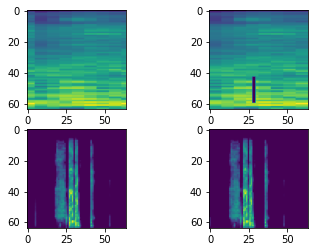

loss tf.Tensor(7.443739, shape=(), dtype=float32)


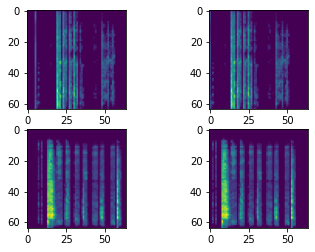

loss tf.Tensor(7.420082, shape=(), dtype=float32)


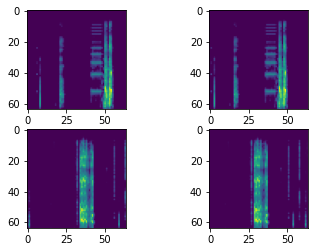

loss tf.Tensor(7.3984985, shape=(), dtype=float32)


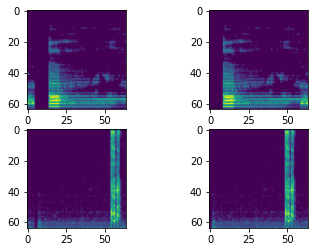

loss tf.Tensor(7.381415, shape=(), dtype=float32)


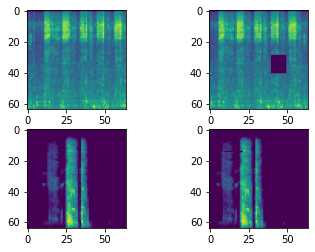

loss tf.Tensor(7.3591566, shape=(), dtype=float32)


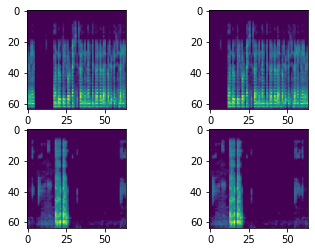

loss tf.Tensor(7.3615956, shape=(), dtype=float32)


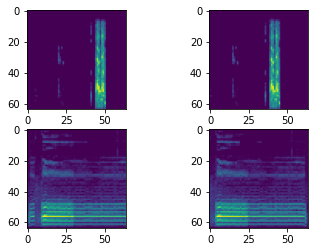

loss tf.Tensor(7.322352, shape=(), dtype=float32)


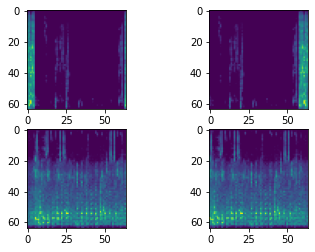

loss tf.Tensor(7.312069, shape=(), dtype=float32)


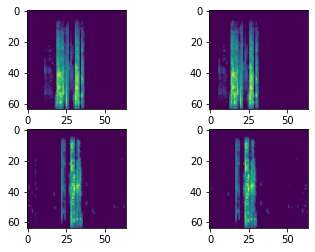

loss tf.Tensor(7.296046, shape=(), dtype=float32)


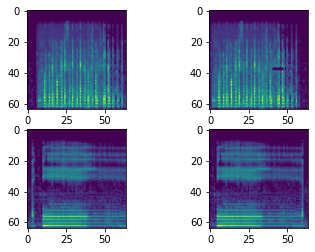

loss tf.Tensor(7.271744, shape=(), dtype=float32)


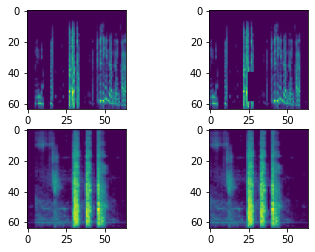

loss tf.Tensor(7.2416697, shape=(), dtype=float32)


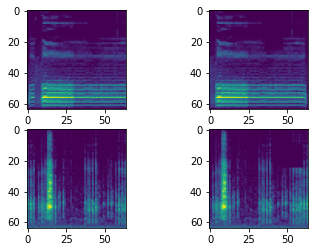

loss tf.Tensor(7.2261333, shape=(), dtype=float32)


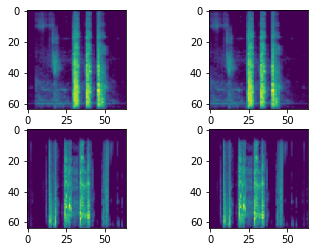

loss tf.Tensor(7.2126665, shape=(), dtype=float32)


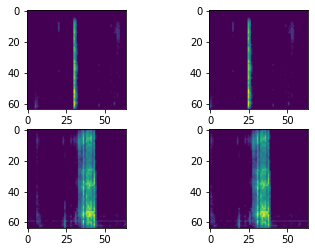

loss tf.Tensor(7.2075377, shape=(), dtype=float32)


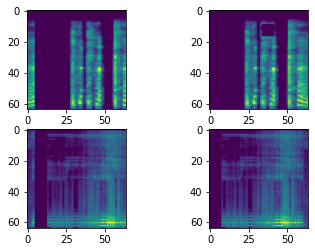

loss tf.Tensor(7.1835575, shape=(), dtype=float32)


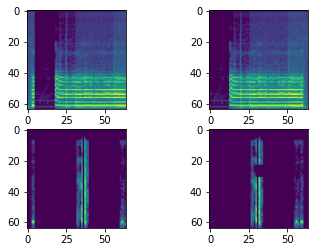

loss tf.Tensor(7.1614313, shape=(), dtype=float32)


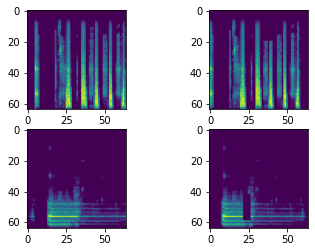

loss tf.Tensor(7.171703, shape=(), dtype=float32)


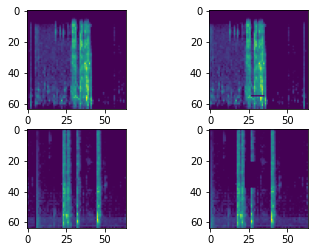

loss tf.Tensor(7.170641, shape=(), dtype=float32)


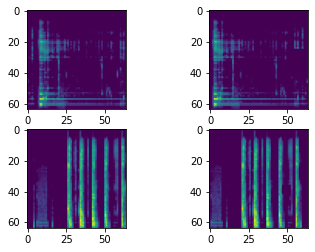

loss tf.Tensor(7.1511226, shape=(), dtype=float32)


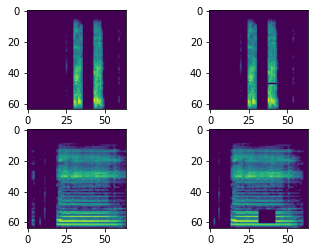

loss tf.Tensor(7.126465, shape=(), dtype=float32)


In [6]:
# Create directory to save models
import tensorflow as tf
import datetime
import os
import yaml
import time
import shutil
import random
import matplotlib.pyplot as plt

NUM_shuf= 1

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    MERGM = build_model_1D()
    
    timgs     = DATA[RUN]['MEL']
    imgs_em  = specGenerator_1D(timgs,batch_size=1028,target_size=(64,64))
    
    negative_mask = get_negative_mask(1028)
    
    train_log_dir = os.path.join('./contrastive/logs_pre_2000_1D_real64', 'train')
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    optimizer = tf.keras.optimizers.Adam(0.0001)


    def train_step(xis, xjs):
        with tf.GradientTape() as tape:

            zis = MERGM(xis)
            zjs = MERGM(xjs)

            # normalize projection feature vectors
            zis = tf.math.l2_normalize(zis, axis=1)
            zjs = tf.math.l2_normalize(zjs, axis=1)

            # tf.summary.histogram('zis', zis, step=optimizer.iterations)
            # tf.summary.histogram('zjs', zjs, step=optimizer.iterations)

            l_pos = _dot_simililarity_dim1(zis, zjs)
            l_pos = tf.reshape(l_pos, (1028, 1))
            l_pos /= 0.5
#             assert l_pos.shape == (48, 1), "l_pos shape not valid" + str(l_pos.shape)  # [N,1]

            negatives = tf.concat([zjs, zis], axis=0)

            loss = 0

            for positives in [zis, zjs]:
                l_neg =  _dot_simililarity_dim2(positives, negatives)

                labels = tf.zeros(1028, dtype=tf.int32)

                l_neg = tf.boolean_mask(l_neg, negative_mask)
                l_neg = tf.reshape(l_neg, (1028, -1))
                l_neg /= 0.5

#                 assert l_neg.shape == (
#                     48, 2 * (48 - 1)), "Shape of negatives not expected." + str(
#                     l_neg.shape)
                logits = tf.concat([l_pos, l_neg], axis=1)  # [N,K+1]
                loss += criterion(y_pred=logits, y_true=labels)

            loss = loss / (2 * 1028)
            tf.summary.scalar('loss', loss, step=optimizer.iterations)
            print('loss',loss)

        gradients = tape.gradient(loss, MERGM.trainable_variables)
        optimizer.apply_gradients(zip(gradients, MERGM.trainable_variables))


    with train_summary_writer.as_default():
        for xis, xjs in imgs_em:
#             print(tf.reduce_min(xis), tf.reduce_max(xjs))
            fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=False)
            axs[0, 0].imshow(xis[1])
            axs[0, 1].imshow(xjs[1])

            axs[1, 0].imshow(xis[8])
            axs[1, 1].imshow(xjs[8])
            plt.show()
#             start = time.time()
            train_step(xis, xjs)
#             end = time.time()
#             print("Total time per batch:", end - start)

    model_checkpoints_folder = os.path.join(train_log_dir, 'checkpoints')
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
    a = 'model'+ str(RUN+1) + '.h5'    
    MERGM.save(os.path.join(model_checkpoints_folder, a))

In [7]:
import pickle
with open('sup_loaded_data_2000.pickle', 'rb') as f:
    sup_DATA = pickle.load(f) 

In [8]:
class sup_CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    min_level_db= -100        
    def normalize_mel(self,S):
        return np.clip((S-min_level_db)/-min_level_db,0,1)


    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img   = self.normalize_mel(img)
            X[i,] = img / self.scale

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)
    
class sup_specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = sup_CustomDataset(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch

In [9]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

class Evaluation(Callback):
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Evaluation, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [10]:
def down_build_model():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

#     # Second Model
#     inp2   = Input(shape=(64,64,3))
#     lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
#     lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
#     lay3_  = BatchNormalization()(lay2_)
#     lay4_  = Activation('relu')(lay3_)

#     lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
#     lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
#     lay7_  = BatchNormalization()(lay6_)
#     lay8_  = Activation('relu')(lay7_)

#     lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
#     lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
#     lay11_ = BatchNormalization()(lay10_)
#     lay12_ = Activation('relu')(lay11_)

#     lay13_ = Flatten()(lay12_)
#     lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
#     lay15_ = Dropout(rate=0.5)(lay14_)

    inp2   = Input(shape=(64,64))
    base_encoder = keras.models.load_model("./contrastive/logs_pre_2000_1D_real64/train/checkpoints/model1.h5")
    base_encoder.trainable = False
    
    h = base_encoder(inp2,training=False)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(h)
    output  = Dense(1, activation='sigmoid')(lay14_)
    sup_MERGM   = Model(inputs=inp2, outputs=output)

    return sup_MERGM

In [11]:
# Create directory to save models
rt_sv_dir = './downstream/downstream_1000_1D_real'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
NUM_shuf= 5

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):    
        sup_MERGM = down_build_model()

        Adam = tf.keras.optimizers.Adam(0.0001)
                                        

        sup_MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
            metrics=['AUC'])

        sup_data_size = len(sup_DATA[RUN]['MEL'])

        sup_timgs     = sup_DATA[RUN]['MEL'][:int(0.4*sup_data_size)]
        sup_labels    = sup_DATA[RUN]['LABELS'][:int(0.4*sup_data_size)]

        sup_test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        sup_test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]

        
        sup_val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
        sup_val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]

        sup_imgs_em      = sup_specGenerator(sup_timgs,sup_labels,batch_size=32,target_size=(64,64))
        TEST          = sup_specGenerator(sup_test_imgs,sup_test_labels,batch_size=32,target_size=(64,64))
        VAL         = sup_specGenerator(sup_val_imgs,sup_val_labels,batch_size=32,target_size=(64,64))
        tf.random.set_seed(6)


        evaluator = Evaluation(VAL, sup_val_labels, TEST, sup_test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
        history = sup_MERGM.fit_generator(
                      sup_imgs_em,
                      epochs=30,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer])
        historys[RUN]=history.history
        

        sup_MERGM_Record1 = sup_MERGM.evaluate_generator(
        TEST
        )

        print()
        print('Results: Loss = {} , AUC = {} '.format(sup_MERGM_Record1[0],sup_MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score


        y_val  = sup_val_labels
        y_preds_val = sup_MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

        y_test  = sup_test_labels
        y_preds_test = sup_MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
Instructions for updating:
Please use Model.predict, which supports generators.
 | val_auc: 0.8235085227272727
 | test_auc: 0.8137974365418448
24/24 - 5s - loss: 0.6805 - auc: 0.7857 - val_loss: 0.6737 - val_auc: 0.8172
Epoch 2/30
 | val_auc: 0.8318790584415584
 | test_auc: 0.8242020608193013
24/24 - 5s - loss: 0.6654 - auc: 0.8289 - val_loss: 0.6594 - val_auc: 0.8301
Epoch 3/30
 | val_auc: 0.831929788961039
 | test_auc: 0.8275697411409902
24/24 - 5s - loss: 0.6499 - auc: 0.8482 - val_loss: 0.6455 - val_auc: 0.8317
Epoch 4/30
 | val_auc: 0.8310673701298701
 | test_auc: 0.8296305604423222
24/24 - 5s - loss: 0.6345 - auc: 0.8569 - val_loss: 0.6315 - val_auc: 0.8311
Epoch 5/30
 | val_auc: 0.8292410714285715
 | test_auc: 0.8287258105051521
24/24 - 5s - loss: 0.6193 - auc: 0.8494 - val_loss: 0.6167 - val_auc: 0.8292
Epoch 6/30
 | val_auc: 0.8283279220779222
 | test_auc: 0.8302839909525006
24/24 - 5s - los

 | test_auc: 0.8436936278094681
24/24 - 6s - loss: 0.4949 - auc: 0.8544 - val_loss: 0.4717 - val_auc: 0.8931
Epoch 18/30
 | val_auc: 0.8931051587301587
 | test_auc: 0.8437911364633611
24/24 - 5s - loss: 0.4896 - auc: 0.8555 - val_loss: 0.4670 - val_auc: 0.8927
Epoch 19/30
 | val_auc: 0.892906746031746
 | test_auc: 0.8438886451172541
24/24 - 6s - loss: 0.4859 - auc: 0.8556 - val_loss: 0.4618 - val_auc: 0.8934
Epoch 20/30
 | val_auc: 0.892361111111111
 | test_auc: 0.8442786797328263
24/24 - 6s - loss: 0.4820 - auc: 0.8562 - val_loss: 0.4583 - val_auc: 0.8918
Epoch 21/30
 | val_auc: 0.8926587301587302
 | test_auc: 0.8446687143483984
24/24 - 6s - loss: 0.4786 - auc: 0.8572 - val_loss: 0.4545 - val_auc: 0.8922
Epoch 22/30
 | val_auc: 0.8931051587301587
 | test_auc: 0.8452537662717566
24/24 - 6s - loss: 0.4756 - auc: 0.8578 - val_loss: 0.4513 - val_auc: 0.8927
Epoch 23/30
 | val_auc: 0.8922619047619047
 | test_auc: 0.8454000292525962
24/24 - 6s - loss: 0.4729 - auc: 0.8586 - val_loss: 0.4489

Epoch 8/30
 | val_auc: 0.8357230845035722
 | test_auc: 0.8614094125797992
24/24 - 5s - loss: 0.5590 - auc: 0.8628 - val_loss: 0.5838 - val_auc: 0.8340
Epoch 9/30
 | val_auc: 0.8367578221236758
 | test_auc: 0.8603701687534023
24/24 - 5s - loss: 0.5448 - auc: 0.8643 - val_loss: 0.5732 - val_auc: 0.8365
Epoch 10/30
 | val_auc: 0.8347868933234787
 | test_auc: 0.8596773395358044
24/24 - 5s - loss: 0.5322 - auc: 0.8647 - val_loss: 0.5643 - val_auc: 0.8361
Epoch 11/30
 | val_auc: 0.8346883468834688
 | test_auc: 0.8591824615232344
24/24 - 5s - loss: 0.5208 - auc: 0.8655 - val_loss: 0.5557 - val_auc: 0.8342
Epoch 12/30
 | val_auc: 0.8341956146834195
 | test_auc: 0.8589845103182067
24/24 - 5s - loss: 0.5107 - auc: 0.8657 - val_loss: 0.5486 - val_auc: 0.8345
Epoch 13/30
 | val_auc: 0.8335550628233553
 | test_auc: 0.8584401445043797
24/24 - 5s - loss: 0.5019 - auc: 0.8661 - val_loss: 0.5421 - val_auc: 0.8333
Epoch 14/30
 | val_auc: 0.8336043360433604
 | test_auc: 0.8586380957094075
24/24 - 5s - lo

 | val_auc: 0.8846882284382285
 | test_auc: 0.8799907744349341
24/24 - 5s - loss: 0.4579 - auc: 0.8672 - val_loss: 0.4441 - val_auc: 0.8843

Results: Loss = 0.449032187461853 , AUC = 0.8798882961273193 

val: 0.8846882284382285
test 0.8799907744349341

-----------------------------------------------------------------
